In [1]:
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.features import compute_returns

from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Lag/window size for Hurst and the ACF
LAG = 1000

## Load market orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

## 1. Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'AAPL': appl_returns
}
returns = {stock: data.head(EVENTS_RANGE) for stock, data in returns.items()}

In [6]:
# Compute ACF for TSLA using the linear method
tsla_acf = compute_acf("TSLA", tsla_returns, option="linear")
display(tsla_acf)

('TSLA',
 0       1.000000
 1      -0.021247
 2       0.006172
 3       0.006995
 4       0.006395
           ...   
 996    -0.000572
 997     0.000437
 998    -0.000019
 999     0.001080
 1000   -0.000295
 Length: 1001, dtype: float64)

### 1.1. Stationarity Test
To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:
- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.
- **H1:** The time series is stationary.
- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [7]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -282.90
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -508.66
p-value: 0.00,
N: 499998, 
critical values: {'1%': -3.4303630787194597, '5%': -2.8615457806400593, '10%': -2.5667730768235435}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -70.00
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -309.36
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.

### 1.2. Return Autocorrelation Functions (ACFs)
There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.
**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.

In [8]:
# Save data for lazy loading
linear_filename = f"{acf_data_dir}/mo_returns_linear_acfs.pkl"

# Linear ACF
linear_acfs = compute_acfs(filename=linear_filename, data=returns, option='linear')
print(linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [9]:
nonlinear_filename = f"{acf_data_dir}/mo_returns_nonlinear_acfs.pkl"

# Nonlinear ACF
nonlinear_acfs = compute_acfs(filename=nonlinear_filename, data=returns, option='nonlinear')
print(nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


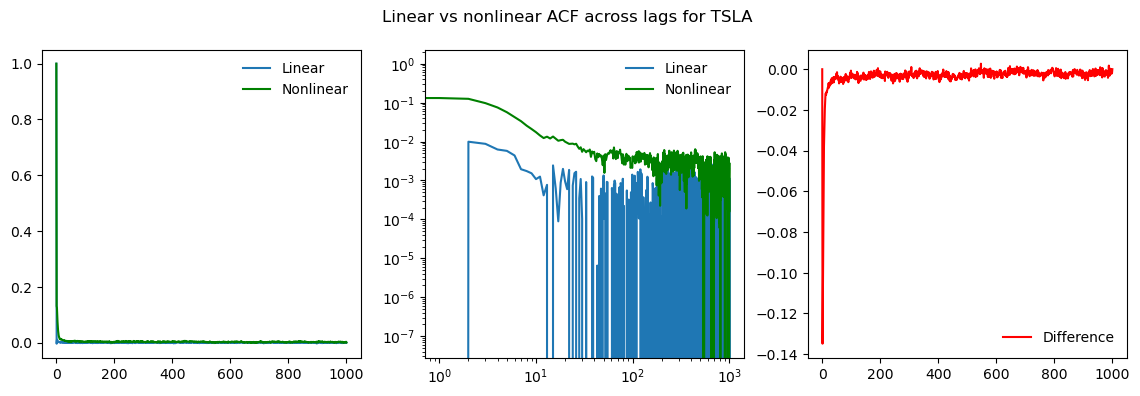

TSLA Max difference: 0.002726712071826322


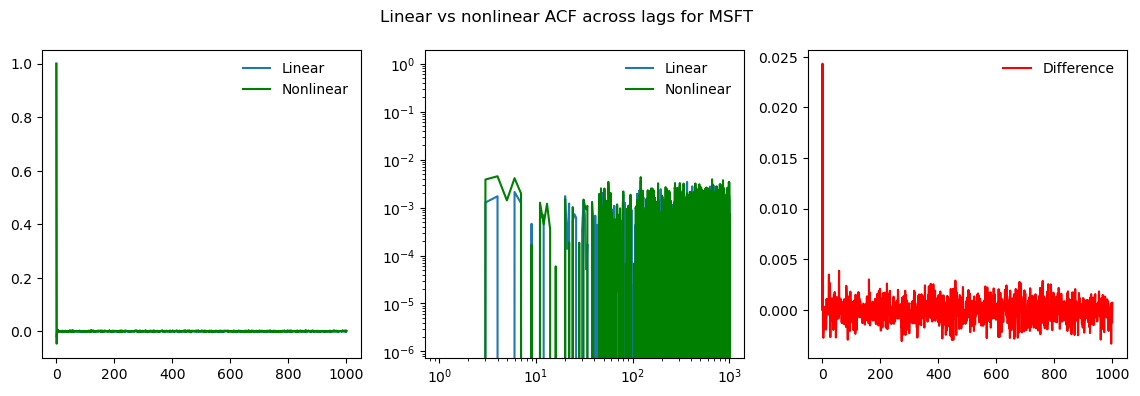

MSFT Max difference: 0.024319853582825596


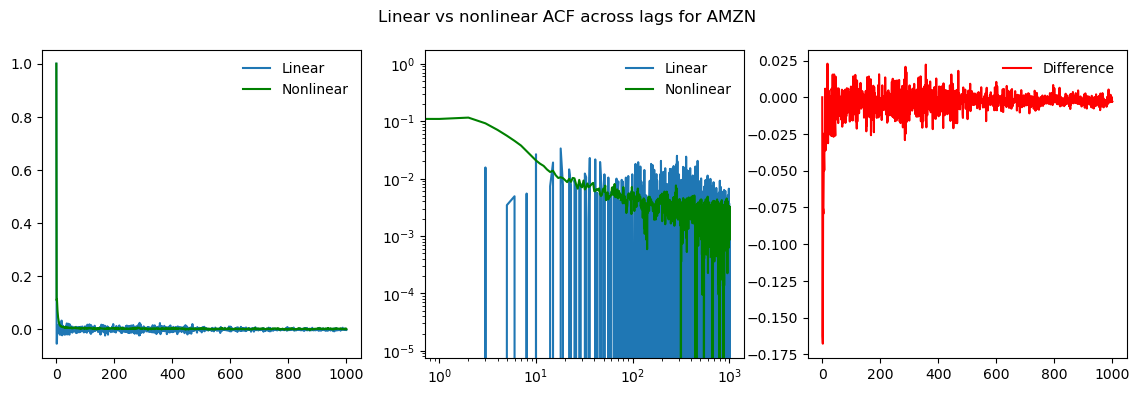

AMZN Max difference: 0.02286291174539908


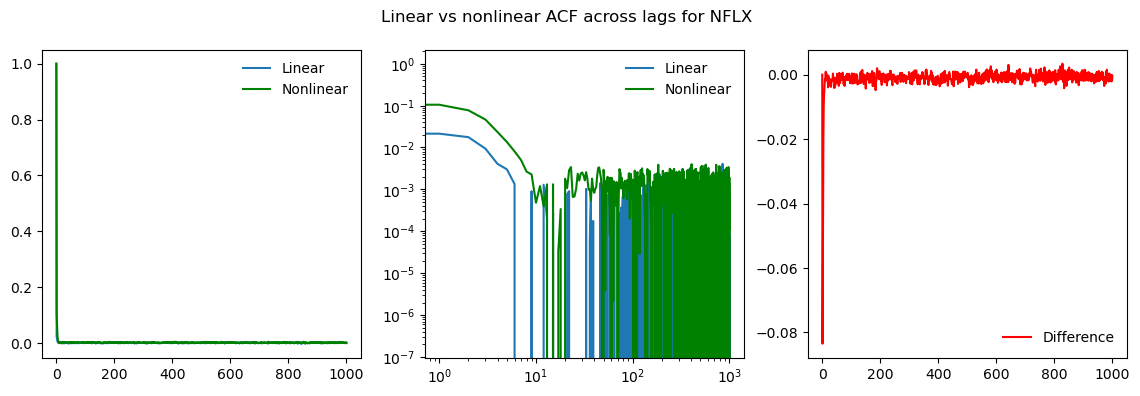

NFLX Max difference: 0.0034026131056620304


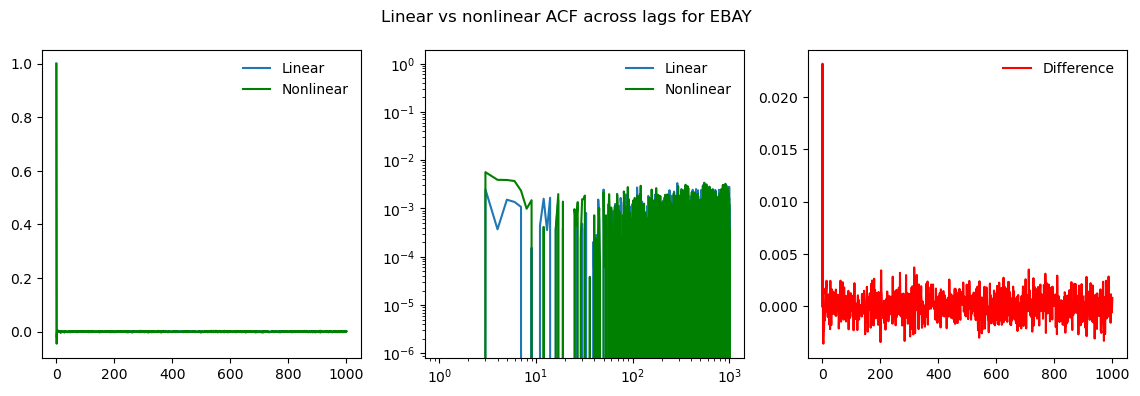

EBAY Max difference: 0.0231628735741536


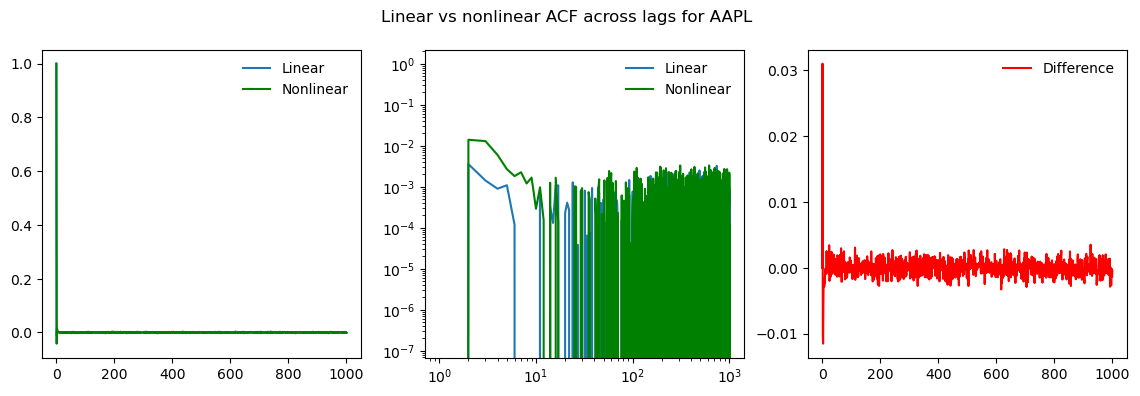

AAPL Max difference: 0.031007579984403705


In [10]:
# Plot differences
# plot_acf_difference("TSLA", linear_acfs, nonlinear_acfs)
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

### 1.3. The Long Memory of Returns?
To determine if a random process exhibits long memory, we take the following approach:
1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.
2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.
3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

#### 1.3.1. Estimate ACF scaling parameter

In [11]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 8
xmin: 9.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.03918049948036577
alpha = -0.4655817976371091

Goodness of fit to data;
D = 0.2366565961732125
bic = -13130.041006141879
mape = 105.85975530502193
Adjusted R-squared = 0.5610352669110745




#### 1.3.2. For all assets

In [12]:
# Load the pre-computed ACFs
return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)

In [13]:
# Using return_acf_values
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
display(acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0305685...",10,11.0,0.263370,-13237.353458,110.020471,0.514692,-0.419566,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.5524219...",10,11.0,0.497477,-13150.789735,103.428918,-0.002792,0.807875,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0410378...",10,11.0,0.220989,-13399.787872,105.671763,0.653262,-0.460193,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0026626...",10,11.0,0.448032,-13539.101242,1623.237157,0.023137,-0.188308,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.250435...",10,11.0,0.490414,-13214.916948,100.541762,0.001590,-2.139894,EBAY


In [14]:
fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [15]:
avg_gamma = acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_gamma}")

Average Gamma: 0.06007863210197314


In [16]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

### 1.4. Estimate Hurst Exponent
The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:
- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.
- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.
- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [17]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['returns'].cumsum()

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.08493897097054094
alpha = 0.5066738129769054

Goodness of fit to data;
D = 0.010109519797809604
bic = -15488.313139446946
mape = 0.21108715317836665
Adjusted R-squared = 0.9999488551933079



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 85
xmin: 8.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.032232829453501054
alpha = 0.5738634417613698

Goodness of fit to data;
D = 0.010879419764279238
bic = -15680.11203486775
mape = 0.2953694445308376
Adjusted R-squared = 0.9999288422993124


Standard Hurst Exponent: 0.5066738129769054 (Super-diffusive: series demonstrates persistent long-range dependence)
Generalized Hurst Exponent: 0.5738634417613698 (Super-diffusive: series demonstrates persistent long-range dependence)


#### 1.4.1 For all assets

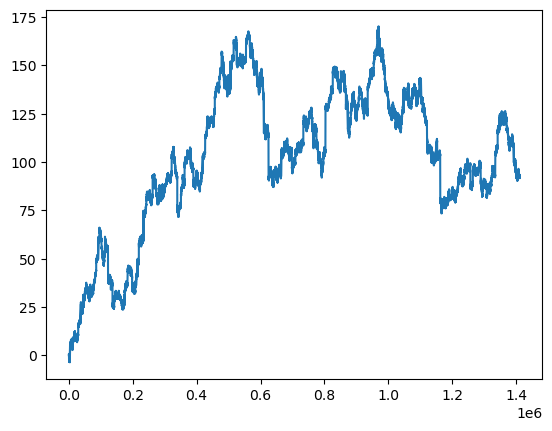

In [18]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df)['returns']
amzn_cum_returns = compute_returns(msft_raw_df)['returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['returns']
msft_cum_returns = compute_returns(nflx_raw_df)['returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['returns']
appl_cum_returns = compute_returns(appl_raw_df)['returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns.cumsum(),
  'MSFT': amzn_cum_returns.cumsum(),
  'AMZN': nflx_cum_returns.cumsum(),
  'NFLX': msft_cum_returns.cumsum(),
  'EBAY': ebay_cum_returns.cumsum(),
  'AAPL': appl_cum_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_returns.items()}
tsla_cumsum_returns = tsla_cum_returns = compute_returns(tsla_raw_df)['returns'].cumsum()
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [19]:
# Standard Hurst
method = 'standard'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
display(std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0803008...",1,2.0,0.016997,-5494.855056,0.769681,0.998892,0.502166,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0082205...",1,2.0,0.012748,-8652.331846,0.796135,0.998662,0.495390,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1343646...",1,2.0,0.029745,-3535.719661,1.823961,0.994926,0.516685,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0283943...",1,2.0,0.014164,-6857.002089,0.814880,0.998702,0.501516,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0097462...",1,2.0,0.012912,-8479.656080,0.706816,0.999012,0.498853,EBAY,returns


In [20]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5021476556560371


In [21]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'returns'), ('MSFT', 'standard', 'returns'), ('AMZN', 'standard', 'returns'), ('NFLX', 'standard', 'returns'), ('EBAY', 'standard', 'returns'), ('AAPL', 'standard', 'returns')])


[autoreload of liquidity.features failed: Traceback (most recent call last):
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/features.py", line 7, in <module>
    from market_impact.response_functions import price_response
ImportError: cannot import name 

In [22]:
# Retrieve standard Hurst fit object for specific 'STOCK'
# tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
# tsla_standard_fit.powerlaw.plot_fit()

#### Generalized Hurst

In [23]:
# Generalized Hurst
method = 'generalized'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method,  max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
display(gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0254926...",1,2.0,0.011331,-7203.200367,0.850405,0.999799,0.606422,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0030618...",1,2.0,0.005666,-10966.044739,0.598829,0.999908,0.585794,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0387110...",1,2.0,0.007082,-6437.929058,0.953987,0.999812,0.627814,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0092755...",1,2.0,0.011331,-8677.838158,0.936485,0.999783,0.597207,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0038028...",1,2.0,0.002869,-12258.564138,0.165985,0.999992,0.581864,EBAY,returns


In [24]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5651002800616147
Max Generalized Hurst: 0.6278140314684265
Average Generalized Hurst: 0.5940335882845463
Standard_dev Generalized Hurst: 0.02171544187800566


In [25]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'returns'), ('MSFT', 'generalized', 'returns'), ('AMZN', 'generalized', 'returns'), ('NFLX', 'generalized', 'returns'), ('EBAY', 'generalized', 'returns'), ('AAPL', 'generalized', 'returns')])


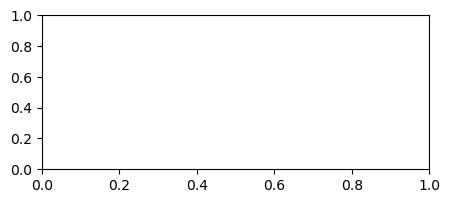

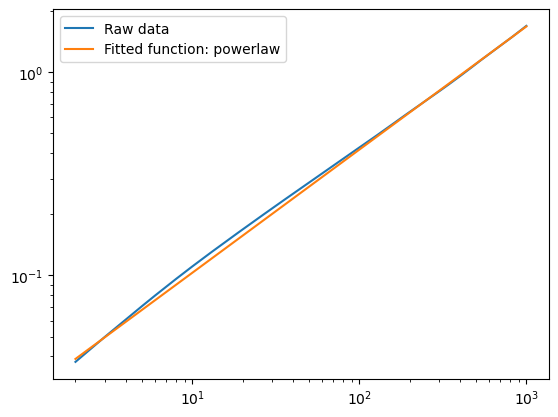

In [26]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]

tsla_generalized_fit.powerlaw.plot_fit()

## 2. Percentage Returns

In [27]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'AAPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### Stationarity Test

In [28]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -283.22
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -509.01
p-value: 0.00,
N: 499998, 
critical values: {'1%': -3.4303630787194597, '5%': -2.8615457806400593, '10%': -2.5667730768235435}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -70.07
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -309.44
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.

### 2.1. Percentage returns ACF

In [29]:
# Linear ACF
percentage_returns_linear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_linear_acfs.pkl"
percentage_returns_linear_acfs = compute_acfs(filename=percentage_returns_linear_acf_filename, data=percentage_returns, option='linear')
print(percentage_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


[autoreload of liquidity.features failed: Traceback (most recent call last):
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/features.py", line 5, in <module>
    from market_impact.response_functions import price_response
ImportError: cannot import name 

In [30]:
# Nonlinear ACF
percentage_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_nonlinear_acfs.pkl"
percentage_returns_nonlinear_acfs = compute_acfs(filename=percentage_returns_nonlinear_acf_filename, data=percentage_returns, option='nonlinear')
print(percentage_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


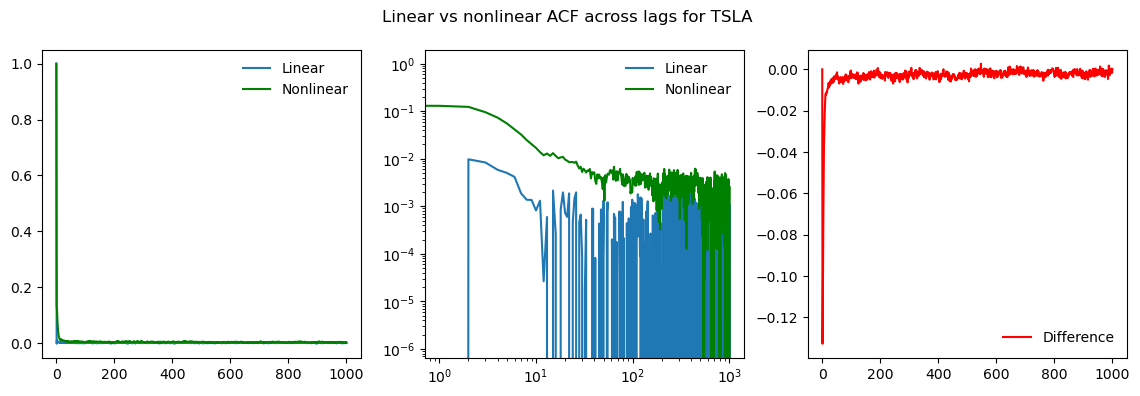

TSLA Max difference: 0.0027181028695633666


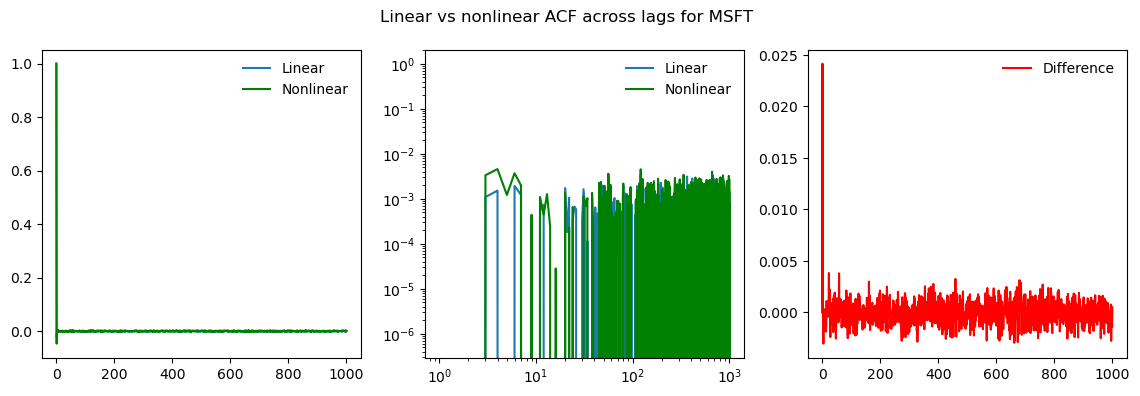

MSFT Max difference: 0.02413973654324126


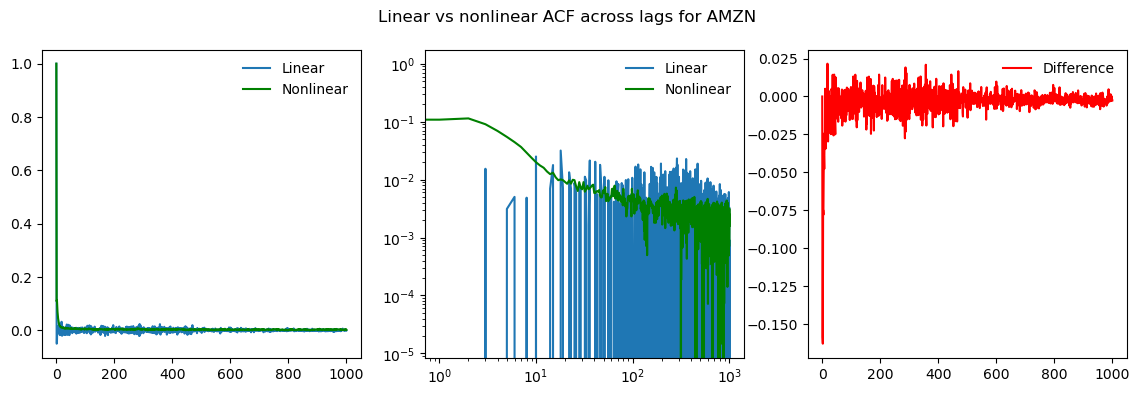

AMZN Max difference: 0.0216204629686998


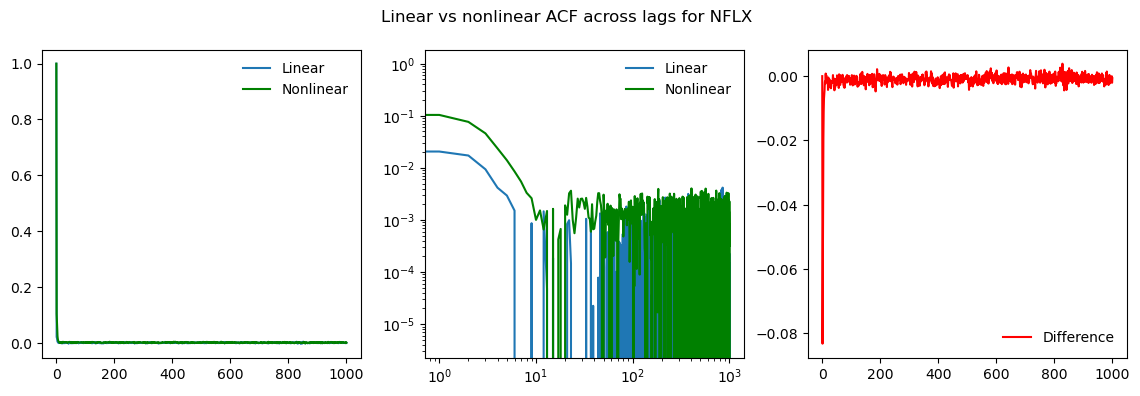

NFLX Max difference: 0.0038797285781675766


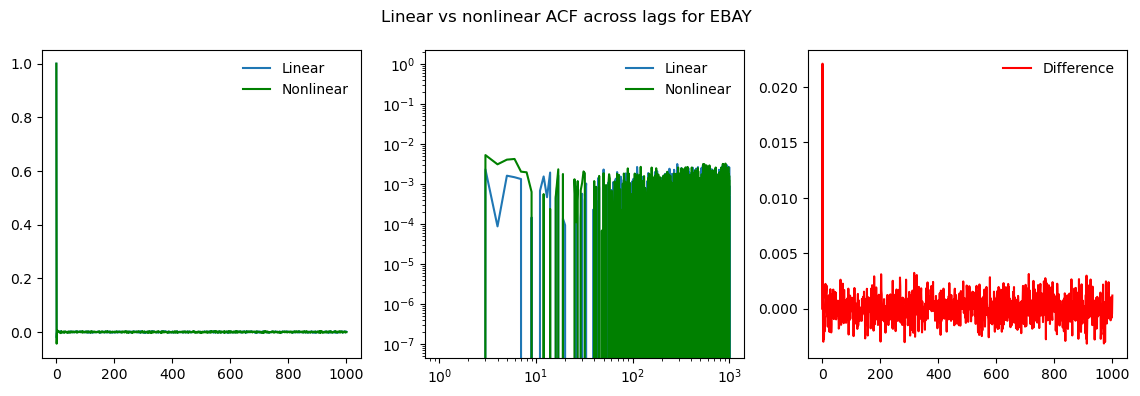

EBAY Max difference: 0.022097401703906047


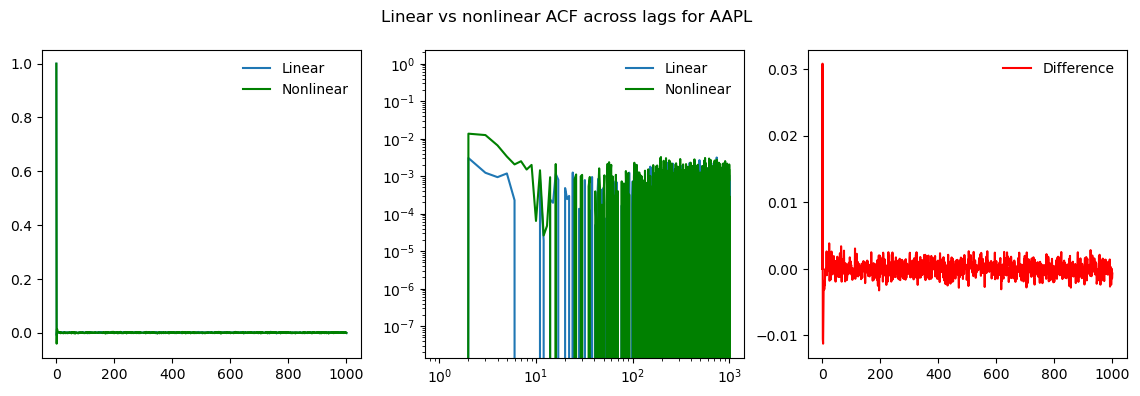

AAPL Max difference: 0.03081473458420795


In [31]:
for stock_name in percentage_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, percentage_returns_linear_acfs, percentage_returns_nonlinear_acfs)

### 2.2. Fit power law to percentage returns ACF

In [32]:
# Load the pre-computed ACFs
percentage_returns_acf_values = {}

for stock, data in percentage_returns_nonlinear_acfs.items():
    percentage_returns_acf_values[stock] = construct_xy(data, stock)

In [33]:
# Using percentage_return_acf_values
percentage_returns_fit_list = []
percentage_returns_fit_objects = {}

for stock, data in percentage_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        percentage_returns_fit_list.append(fit_dict)
        percentage_returns_fit_objects[stock] = fit_obj  # Store the fit object

percentage_returns_fit_results = pd.DataFrame(percentage_returns_fit_list)
display(percentage_returns_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0301118...",10,11.0,0.271443,-13269.562387,241.524307,0.514353,-0.422320,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.9248226...",10,11.0,0.498486,-13177.001528,100.095066,-0.002825,0.914528,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0405741...",10,11.0,0.226034,-13438.075604,322.003775,0.650510,-0.466487,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0027790...",10,11.0,0.448032,-13591.502930,384.398466,0.025828,-0.183732,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -4.336763...",10,11.0,0.494450,-13239.955042,100.076603,-0.000351,-3.364192,EBAY


In [34]:
percentage_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [35]:
avg_alpha = percentage_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.15372453019309348


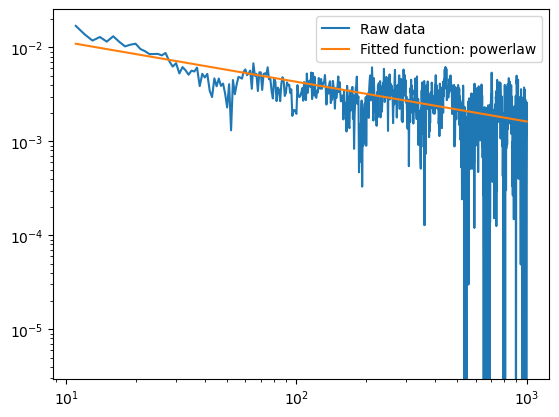

In [36]:
tsla_acf_fit = percentage_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3 Percentage returns Hurst Exponents

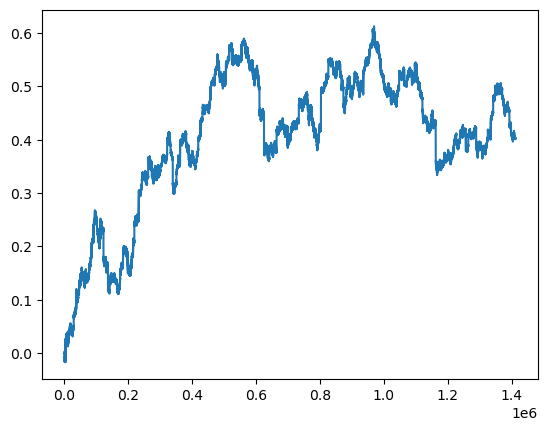

In [37]:
# Compute cumsum of percentage returns
cumsum_percentage_returns = {
  'TSLA': tsla_percentage_returns.cumsum(),
  'MSFT': msft_percentage_returns.cumsum(),
  'AMZN': amzn_percentage_returns.cumsum(),
  'NFLX': nflx_percentage_returns.cumsum(),
  'EBAY': ebay_percentage_returns.cumsum(),
  'AAPL': appl_percentage_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_percentage_returns.items()}
tsla_cumsum_percentage_returns = tsla_percentage_returns.cumsum()
x = list(range(1, len(tsla_cumsum_percentage_returns)+1))
plt.plot(x, tsla_cumsum_percentage_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [38]:
# Standard Hurst
method = 'standard'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_std_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002874...",1,2.0,0.019830,-13424.136267,0.787962,0.998803,0.499316,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001235...",1,2.0,0.012748,-14588.122400,0.793248,0.998664,0.494671,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001495...",1,2.0,0.026912,-13257.718850,1.711841,0.995634,0.515487,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001953...",1,2.0,0.012748,-13919.704301,0.826839,0.998795,0.503378,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002826...",1,2.0,0.011478,-13411.450723,0.715602,0.999006,0.498747,EBAY,percentage_returns


In [39]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = percentage_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5017478823486315


In [40]:
display(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'percentage_returns'), ('MSFT', 'standard', 'percentage_returns'), ('AMZN', 'standard', 'percentage_returns'), ('NFLX', 'standard', 'percentage_returns'), ('EBAY', 'standard', 'percentage_returns'), ('AAPL', 'standard', 'percentage_returns')])

#### Generalized Hurst

In [41]:
# Generalized Hurst
method = 'generalized'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_gen_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.8244437...",1,2.0,0.011331,-15139.316820,0.893026,0.999783,0.607671,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.6142990...",1,2.0,0.005666,-16897.244460,0.597107,0.999909,0.585396,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.2782791...",1,2.0,0.007082,-15988.146376,0.990392,0.999798,0.628722,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.3347397...",1,2.0,0.011331,-15655.268268,0.972442,0.999767,0.598211,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001082...",1,2.0,0.002869,-17232.141187,0.161766,0.999992,0.582761,EBAY,percentage_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.4432815...",1,2.0,0.004249,-17762.653069,0.478003,0.999937,0.567800,AAPL,percentage_returns


In [42]:
# Generalized Hurst statistic across stocks
min_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = percentage_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5678001180088945
Max Generalized Hurst: 0.6287224738316562
Average Generalized Hurst: 0.5950935874671934
Standard_dev Generalized Hurst: 0.021400306745659865


In [43]:
print(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'percentage_returns'), ('MSFT', 'generalized', 'percentage_returns'), ('AMZN', 'generalized', 'percentage_returns'), ('NFLX', 'generalized', 'percentage_returns'), ('EBAY', 'generalized', 'percentage_returns'), ('AAPL', 'generalized', 'percentage_returns')])


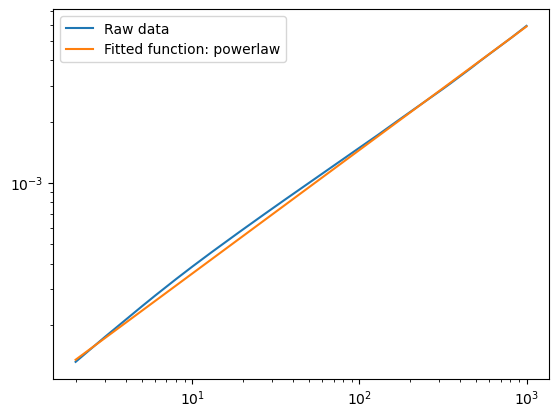

In [44]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = percentage_returns_fit_objects[('TSLA', 'generalized', 'percentage_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Log Returns

In [45]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df)['log_returns']
msft_log_returns = compute_returns(msft_raw_df)['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df)['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df)['log_returns']
appl_log_returns = compute_returns(appl_raw_df)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'AAPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### Stationarity Test

In [46]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -283.20
p-value: 0.00,
N: 499993, 
critical values: {'1%': -3.4303630788502493, '5%': -2.8615457806978664, '10%': -2.566773076854312}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -509.02
p-value: 0.00,
N: 499997, 
critical values: {'1%': -3.4303630787456174, '5%': -2.8615457806516207, '10%': -2.5667730768296972}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -70.13
p-value: 0.00,
N: 499897, 
critical values: {'1%': -3.430363081361919, '5%': -2.8615457818079926, '10%': -2.566773077445192}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -309.32
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


### 3.1. Log returns ACF

In [47]:
# Linear ACF
log_returns_linear_acf_filename = f"{acf_data_dir}/mo_log_returns_linear_acfs.pkl"
log_returns_linear_acfs = compute_acfs(filename=log_returns_linear_acf_filename, data=log_returns, option='linear')
print(log_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [48]:
# Nonlinear ACF
log_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_log_returns_nonlinear_acfs.pkl"
log_returns_nonlinear_acfs = compute_acfs(filename=log_returns_nonlinear_acf_filename, data=log_returns, option='nonlinear')
print(log_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


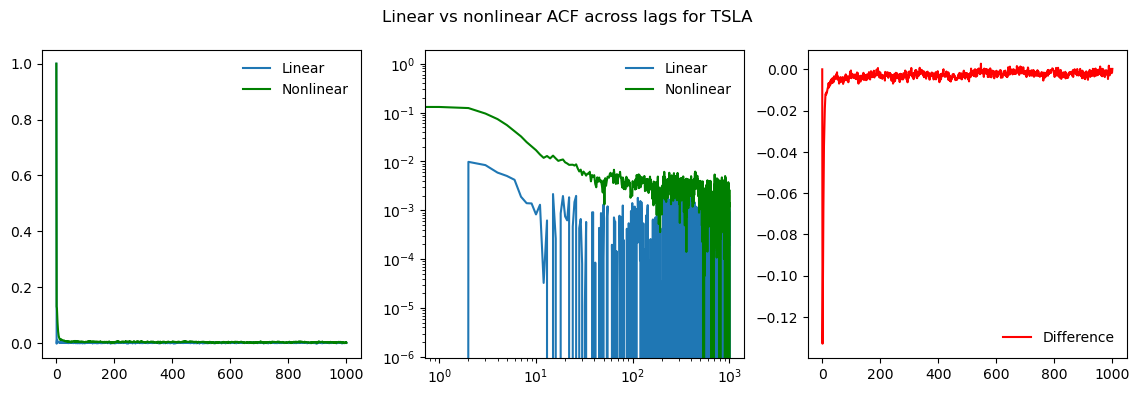

TSLA Max difference: 0.0027326150422147446


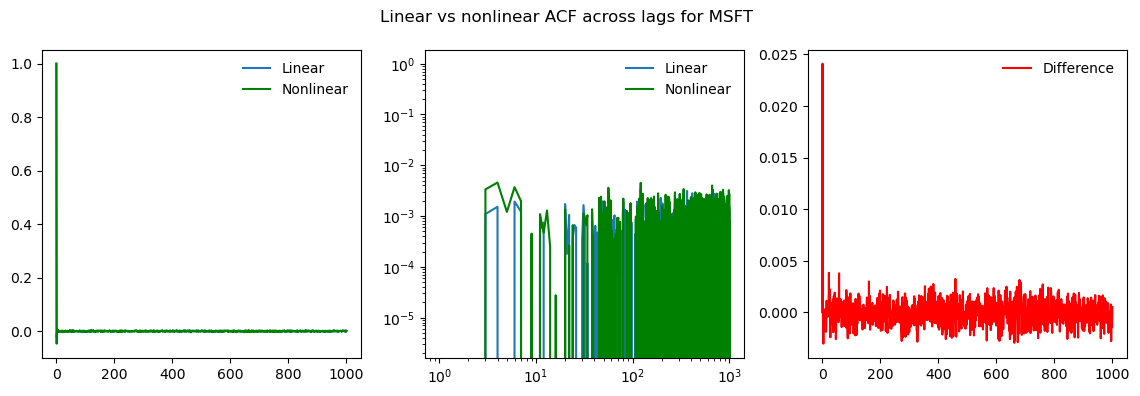

MSFT Max difference: 0.024104814891820266


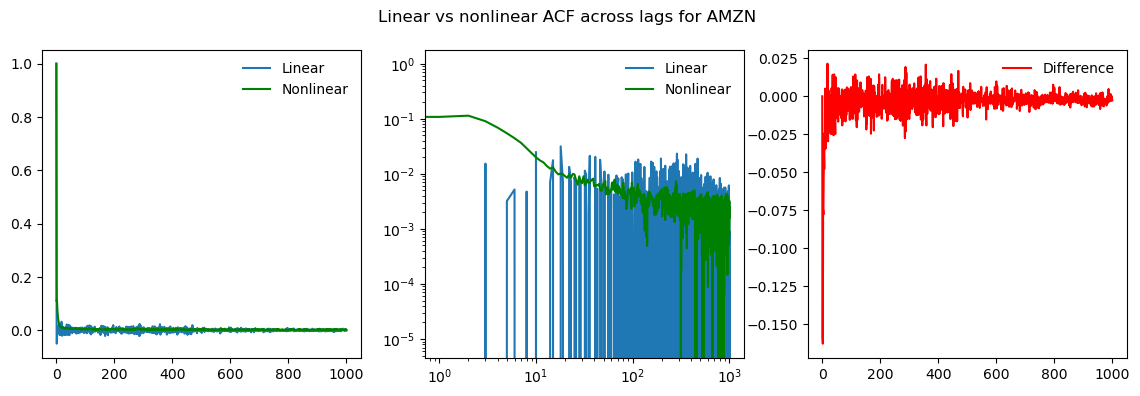

AMZN Max difference: 0.021498506786634834


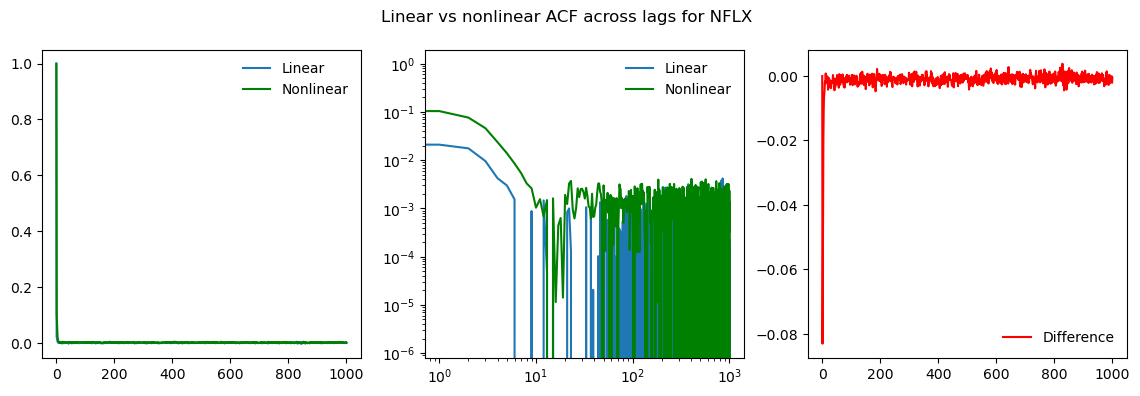

NFLX Max difference: 0.0038211879438240057


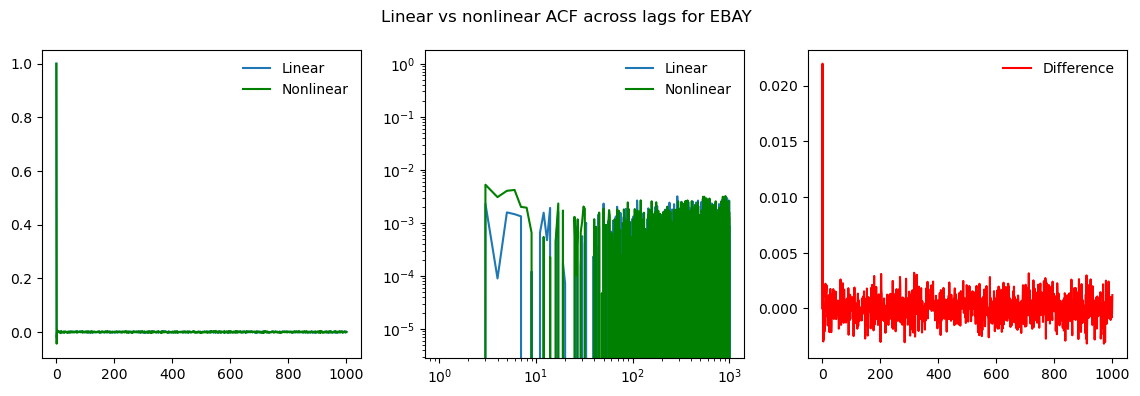

EBAY Max difference: 0.021975478904952404


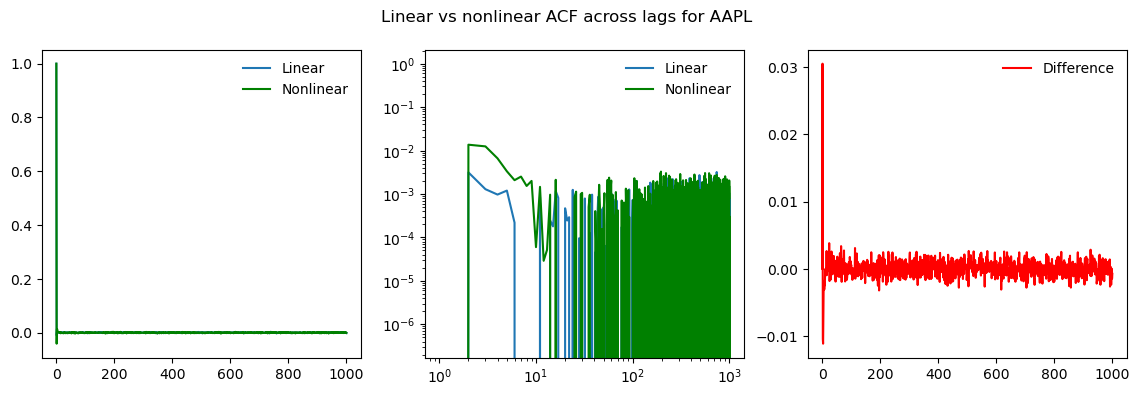

AAPL Max difference: 0.03055447282735252


In [49]:
for stock_name in log_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, log_returns_linear_acfs, log_returns_nonlinear_acfs)

### 3.2. Fit power law to log retrurns ACF

In [50]:
# Load the pre-computed ACFs
log_returns_acf_values = {}

for stock, data in log_returns_nonlinear_acfs.items():
    log_returns_acf_values[stock] = construct_xy(data, stock)

In [51]:
# Using log_returns_nonlinear_acfs
log_returns_fit_results_list = []
log_returns_fit_objects = {}  # Dictionary to store fit objects

for stock, data in log_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[stock] = fit_obj  # Store the fit object

log_returns_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0300836...",10,11.0,0.269425,-13267.819891,936.238965,0.513934,-0.421865,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.3476562...",10,11.0,0.501514,-13175.797066,100.197554,-0.003030,0.023747,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0405195...",10,11.0,0.225025,-13437.101398,152.319662,0.650157,-0.466113,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0027647...",10,11.0,0.442987,-13588.336834,368.532004,0.025381,-0.182497,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -4.327611...",10,11.0,0.494450,-13241.450424,100.096162,-0.000353,-3.363567,EBAY
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.1854019...",10,11.0,0.494450,-13372.330583,116.407611,-0.001329,2.575348,AAPL


In [52]:
log_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [53]:
avg_alpha = log_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.3058244273572835


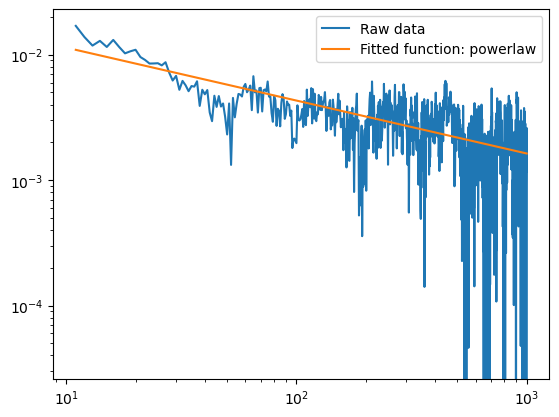

In [54]:
tsla_acf_fit = log_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Log returns Hurst Exponents

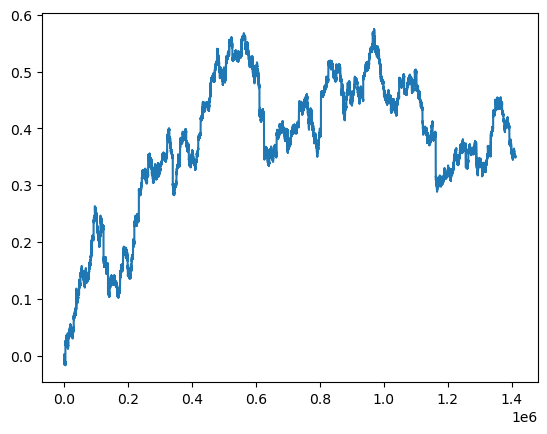

In [55]:
cumsum_log_returns = {
  'TSLA': tsla_log_returns.cumsum(),
  'MSFT': msft_log_returns.cumsum(),
  'AMZN': amzn_log_returns.cumsum(),
  'NFLX': nflx_log_returns.cumsum(),
  'EBAY': ebay_log_returns.cumsum(),
  'AAPL': appl_log_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_log_returns.items()}
tsla_cumsum_log_returns = compute_returns(tsla_raw_df)['log_returns'].cumsum()
x = list(range(1, len(tsla_cumsum_log_returns)+1))
plt.plot(x, tsla_cumsum_log_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [56]:
# Standard Hurst
method = 'standard'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_std_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_std_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002866...",1,2.0,0.021246,-13418.237006,0.793488,0.998790,0.499529,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001235...",1,2.0,0.012748,-14580.260059,0.791983,0.998648,0.494580,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001498...",1,2.0,0.025496,-13281.958977,1.700771,0.995755,0.514849,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001935...",1,2.0,0.012748,-13924.684889,0.831392,0.998782,0.503449,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002811...",1,2.0,0.014347,-13411.879288,0.724631,0.999002,0.499148,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001161...",1,2.0,0.009915,-14990.150682,0.586943,0.999197,0.498839,AAPL,log_returns


In [57]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = log_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.501732362675831


In [58]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'log_returns'), ('MSFT', 'standard', 'log_returns'), ('AMZN', 'standard', 'log_returns'), ('NFLX', 'standard', 'log_returns'), ('EBAY', 'standard', 'log_returns'), ('AAPL', 'standard', 'log_returns')])

#### Generalized Hurst

In [59]:
# Generalized Hurst
method = 'generalized'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_gen_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/a

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.8385309...",1,2.0,0.011331,-15147.651928,0.887736,0.999785,0.607238,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.6155160...",1,2.0,0.005666,-16897.568740,0.596725,0.999909,0.585319,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.2909944...",1,2.0,0.007082,-16005.869421,0.977450,0.999802,0.628083,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.3470291...",1,2.0,0.011331,-15664.985681,0.966161,0.999769,0.597658,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001083...",1,2.0,0.002869,-17226.997172,0.161781,0.999992,0.582586,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.4523015...",1,2.0,0.004249,-17765.310388,0.474968,0.999937,0.567092,AAPL,log_returns


In [60]:
# Generalized Hurst statistic across stocks
min_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = log_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5670923365273219
Max Generalized Hurst: 0.6280829457628123
Average Generalized Hurst: 0.594662769686645
Standard_dev Generalized Hurst: 0.021341464850358222


In [61]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'log_returns'), ('MSFT', 'generalized', 'log_returns'), ('AMZN', 'generalized', 'log_returns'), ('NFLX', 'generalized', 'log_returns'), ('EBAY', 'generalized', 'log_returns'), ('AAPL', 'generalized', 'log_returns')])

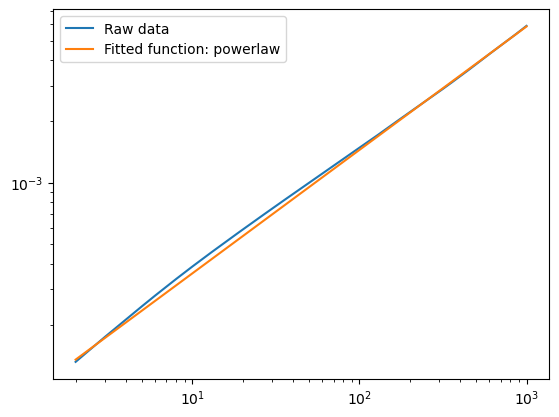

In [62]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = log_returns_fit_objects[('TSLA', 'generalized', 'log_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 4. Return magnitudes

In [63]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'AAPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

### Stationarity Test

In [64]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -69.41
p-value: 0.00,
N: 499918, 
critical values: {'1%': -3.4303630808124086, '5%': -2.861545781565116, '10%': -2.5667730773159176}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -50.66
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -44.04
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -57.88
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 4.1. Return magnitude ACF

In [65]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/mo_volatility_linear_acfs.pkl"
volatility_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
display(volatility_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [66]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/mo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
display(volatility_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

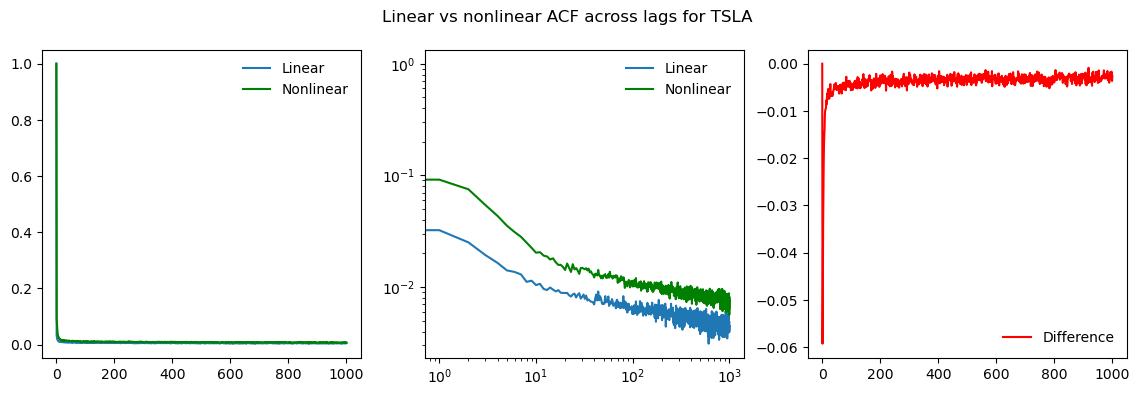

TSLA Max difference: -2.220446049250313e-16


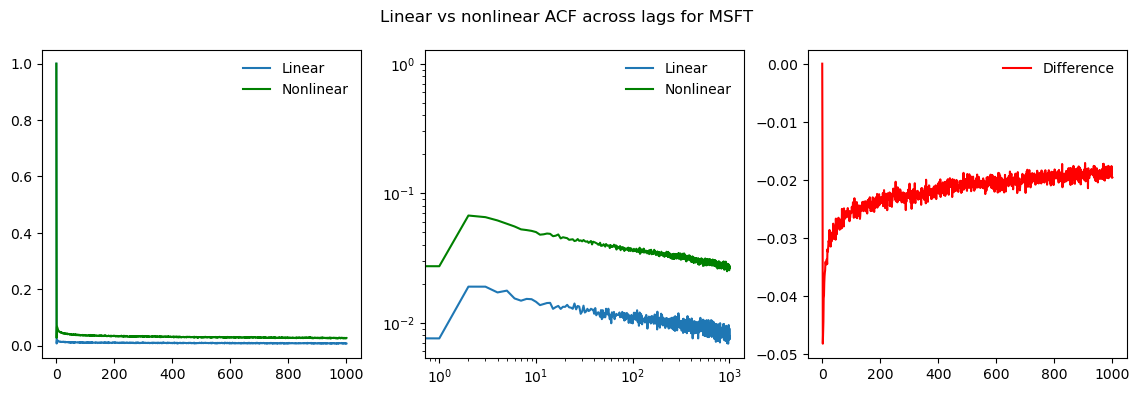

MSFT Max difference: 0.0


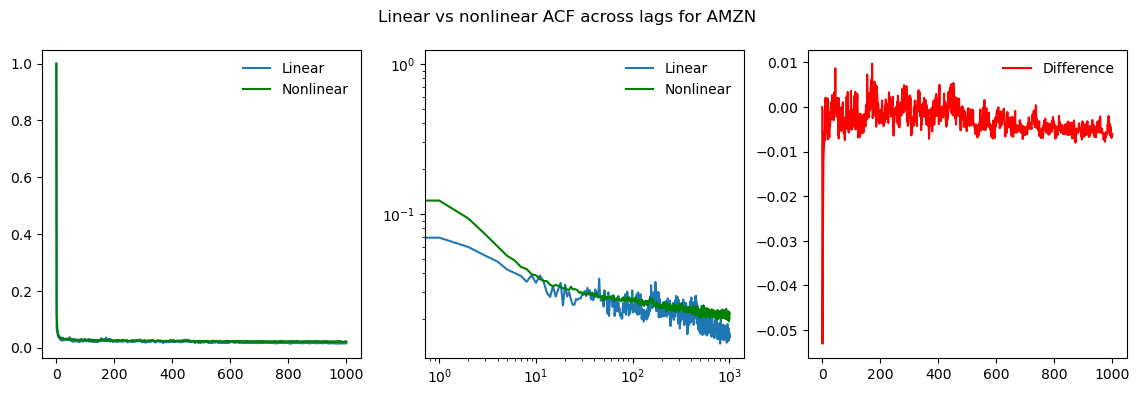

AMZN Max difference: 0.00972687792182379


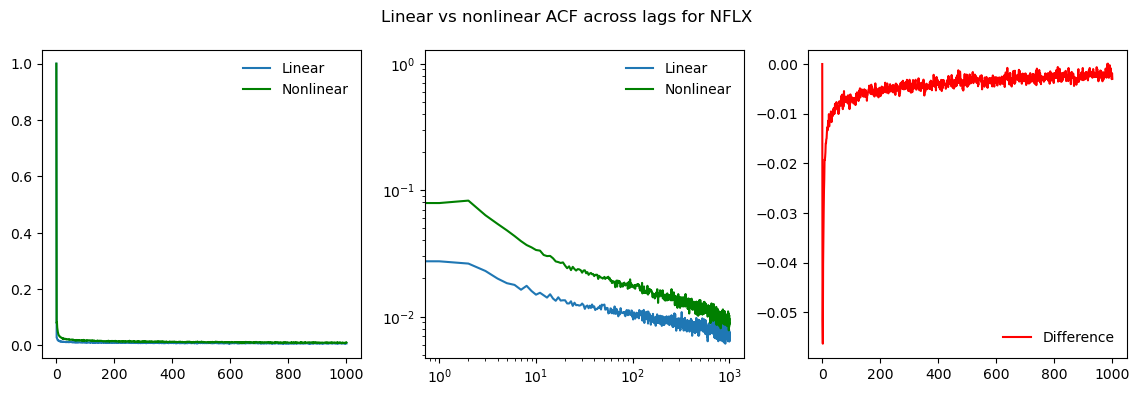

NFLX Max difference: 7.103158473332257e-05


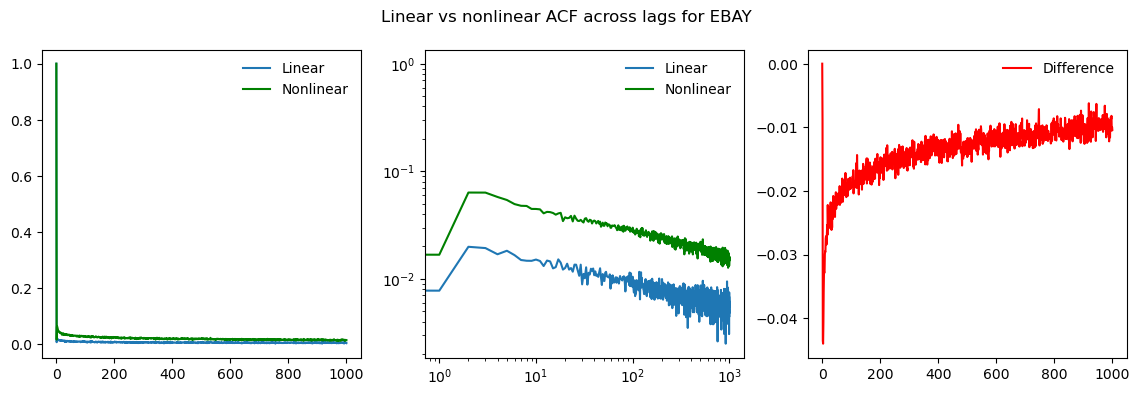

EBAY Max difference: 1.1102230246251565e-16


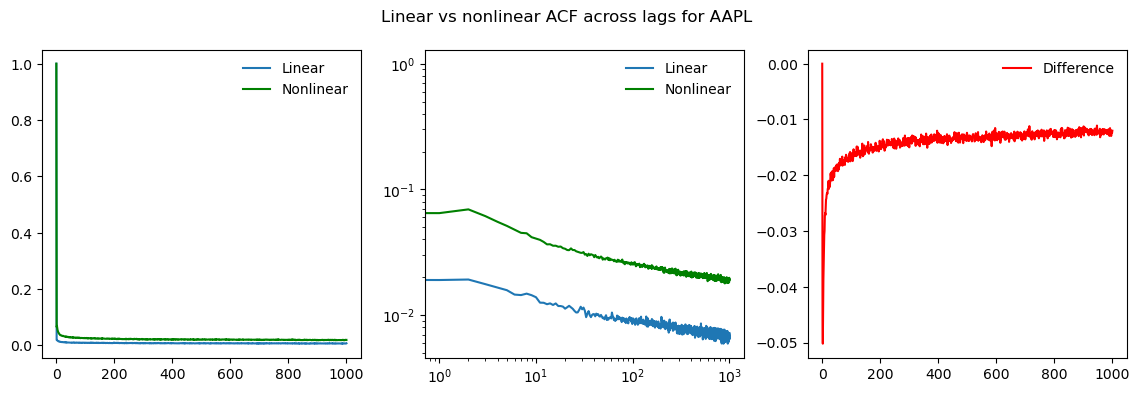

AAPL Max difference: 0.0


In [67]:
for stock_name in volatility_linear_acfs.keys():
    plot_acf_difference(stock_name, volatility_linear_acfs, volatility_nonlinear_acfs)

### 4.2. Fit power law to ACF

In [68]:
# Load the pre-computed ACFs
volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [69]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0278934...",8,9.0,0.101712,-14318.571385,6.182434,0.850361,-0.193309,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0690670...",3,4.0,0.090180,-13922.137303,2.260912,0.958031,-0.134541,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0448830...",7,8.0,0.076459,-14001.544329,2.669001,0.894586,-0.112733,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0636205...",4,5.0,0.095286,-13789.524671,5.002743,0.945689,-0.275561,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0967982...",110,111.0,0.123457,-11866.933183,5.472564,0.852237,-0.263528,EBAY


In [70]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.1855934181922968


In [71]:
volatility_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

### 4.3.Volatility Hurst Exponents

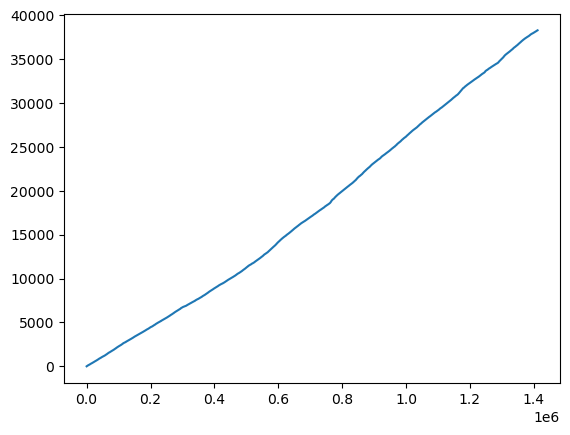

In [72]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

cumsum_return_magnitudes = {
  'TSLA': tsla_volatility.cumsum(),
  'MSFT': msft_volatility.cumsum(),
  'AMZN': amzn_volatility.cumsum(),
  'NFLX': nflx_volatility.cumsum(),
  'EBAY': ebay_volatility.cumsum(),
  'AAPL': appl_volatility.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
tsla_cumsum_abs_returns = tsla_volatility.cumsum()
x = list(range(1, len(tsla_cumsum_abs_returns)+1))
plt.plot(x, tsla_cumsum_abs_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [73]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0376677...",1,2.0,0.015581,-4563.092515,2.268752,0.998729,0.682113,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0023324...",1,2.0,0.011331,-7616.937335,2.495105,0.999553,0.839164,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0691205...",1,2.0,0.018414,-755.010885,3.196864,0.994315,0.865638,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0097762...",1,2.0,0.012748,-5969.845802,2.544673,0.999124,0.755860,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0030227...",1,2.0,0.011478,-7389.339927,2.344693,0.999568,0.818522,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0059642...",1,2.0,0.018414,-6912.146092,2.619330,0.998881,0.715469,AAPL,volatility


In [74]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.7794610493967086


#### Generalized Hurst

In [75]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0225402...",1,2.0,0.001416,-10638.817812,0.012212,1.0,0.999613,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0029170...",1,2.0,0.001416,-15432.655044,0.003328,1.0,0.999820,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0389596...",1,2.0,0.001416,-10100.802473,0.011643,1.0,0.999630,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0094019...",1,2.0,0.001416,-13459.343032,0.001296,1.0,0.999904,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0035728...",1,2.0,0.001435,-13245.737255,0.009992,1.0,0.999806,EBAY,volatility


In [76]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9996128564460067
Max Generalized Hurst: 0.9999197612330074
Average Generalized Hurst: 0.999782173036034
Standard_dev Generalized Hurst: 0.00013235182665300482


In [77]:
print(volatility_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volatility'), ('MSFT', 'generalized', 'volatility'), ('AMZN', 'generalized', 'volatility'), ('NFLX', 'generalized', 'volatility'), ('EBAY', 'generalized', 'volatility'), ('AAPL', 'generalized', 'volatility')])


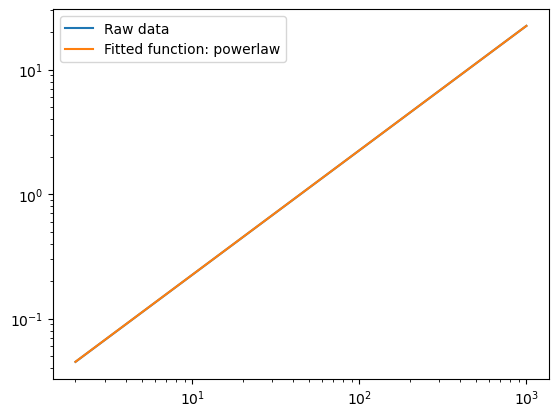

In [78]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volatility_fit_objects[('TSLA', 'generalized', 'volatility')]
tsla_generalized_fit.powerlaw.plot_fit()